# Инструменты для работы с языком 

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [1]:
# если у вас линукс / мак / collab или ещё какая-то среда, в которой работает wget, можно так:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2022-06-03 12:55:15--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Распознаётся www.dropbox.com (www.dropbox.com)… 162.125.72.18
Подключение к www.dropbox.com (www.dropbox.com)|162.125.72.18|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: /s/raw/fnpq3z4bcnoktiv/positive.csv [переход]
--2022-06-03 12:55:15--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://ucc9e5f032a76be408ce4b37732a.dl.dropboxusercontent.com/cd/0/inline/Bmcsa0uTCxDH270rBZRLi0s8qQmapcjD2VldtLdLqcMbY_7-pMvBWvGLMK38Qlk331Lu-0J_kAwjMYrZuBI2Y5j-EV8UpCzpDapRo0t8VHfMx7XW-01CQl3O8-B-JlZFaoAGd3tpifcoU8fYd56B5YV3LGKPXGgO4upaldNcQYQqdA/file# [переход]
--2022-06-03 12:55:16--  https://ucc9e5f032a76be408ce4b37732a.dl.dropboxusercontent.com/cd/0/inline/Bmcsa0uTCxDH270rBZRLi0s8qQmapcjD2VldtLdLqcMbY_7-pMvBWvGLMK38Qlk331Lu-0J_kAwjMYrZuBI2

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [5]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [8]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [20]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [19]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [17]:
from nltk import ngrams

In [18]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [19]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [20]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [21]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [22]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [23]:
list(vec.vocabulary_.items())[:10]

[('alpirat', 11488),
 ('cio_optimal', 21163),
 ('ну', 169340),
 ('пошалил', 191439),
 ('кем', 144354),
 ('не', 165259),
 ('бывает', 109141),
 ('главное', 119882),
 ('человек', 236354),
 ('хороший', 233995)]

In [28]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

/Users/janeyaromich/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [29]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.77      0.75      0.76     28202
    positive       0.76      0.77      0.77     28507

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Попробуем сделать то же самое для триграмм:

In [30]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/Users/janeyaromich/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.85      0.57      0.68     41286
    positive       0.39      0.73      0.51     15423

    accuracy                           0.61     56709
   macro avg       0.62      0.65      0.59     56709
weighted avg       0.72      0.61      0.63     56709



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

In [39]:
vec_uno_gramm = CountVectorizer(ngram_range=(1, 1))
vec_uno_gramm.fit(x_train)
print('Vec dim with tree-gramm:', len(vec_uno_gramm.vocabulary_))

vec_tree_gramm = CountVectorizer(ngram_range=(3, 3))
vec_tree_gramm.fit(x_train)
print('Vec dim with tree-gramm:', len(vec_tree_gramm.vocabulary_))

Vec dim with tree-gramm: 243577
Vec dim with tree-gramm: 1327636


**`Ответ`**: Три-граммы в жизни встречаются не так уж часто, по сравнению с уни-граммами. n-граммы полезны для создание векторов которые несут другой смысл по сравнению тремя уни-граммами. Примером могут быть различные устойчивые выражения (а их значительно меньше чем уни-грамм). 

Из вышесказанного следует, что применение три-грамм в лоб не только не поможет, но и усугубит ситуацию. Применив три-граммы в лоб, мы увеличиваем размерность пространсва на порядок (вероятность встретить одинаковые три-граммы значительно ниже вероятности встретить одинаковые слова). Так же извесно, что линейные классификаторы страдают проклятием размерности.

Из вышесказаного становится понятны полученые результаты

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом 
количестве документов, у него высокий TF-IDF.

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.73      0.76      0.75     26459
    positive       0.79      0.75      0.77     30250

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



В этот раз получилось хуже :( Вернёмся к `CountVectorizer`.

## PMI

Можно оценить взаимосвязь слов в корпусе и понять, какие биграммы наиболее часто встречаются в тексте. Для этого можно использовать метрику PMI (Pointwise Mutual Information) - поточечная взаимная информация. Метрика PMI для двух слов вычисляется по формуле:

$$pmi(x; y) = log \frac{p(x,y)}{p(x)p(y)} $$

Здесь p(y|x) - вероятность встретить слово $y$ после $x$, $p(y)$ - вероятность встретить слово $y$.

Оценим важность биграмм в нашем обучающем корпусе.

In [43]:
import nltk
from nltk import collocations 
nltk.download('genesis')

print(type(nltk.corpus.genesis.words('english-web.txt')))
bigram_measures = collocations.BigramAssocMeasures()
# bigram_finder.apply_freq_filter(5)
bigram_finder = collocations.BigramCollocationFinder.from_documents([nltk.word_tokenize(x) for x in x_train])
bigrams = bigram_finder.nbest(bigram_measures.pmi, 100)
print(bigrams)

[nltk_data] Downloading package genesis to
[nltk_data]     /Users/janeyaromich/nltk_data...
[nltk_data]   Unzipping corpora/genesis.zip.


<class 'nltk.corpus.reader.util.StreamBackedCorpusView'>
[('+1239', '728'), ('+375447167151', 'звоги'), ('+живіт', 'болить.ну'), ('+погода', 'крутая='), (',4', 'запирайте'), (',Дела', 'рез'), (',как', 'додики'), ('-/////', 'прбрм-прбрм'), ('-10,11', 'болсо'), ('-53', 'dBm'), ('-800', 'нахууй'), ('-АХАХАХАХ', 'ЮБКУ'), ('-АХАХАХАХХАХАХАХАХАХХА', '-АХАХАХХАХАХАХАХАХ'), ('-Айгуль', 'Маратовна'), ('-Алина', '-Синие'), ('-Белоснежная', 'мантия'), ('-ВАХАХАХА', 'СТИПЕНДИЯ'), ('-ВСЕМ', 'СПОКОЙНЫХ'), ('-Весело', 'кншн:3'), ('-Выздоравливай', 'педрилк'), ('-ДЕТЕЙ', 'НАКРЫЛО'), ('-ДОВАЙТИ', 'АЛДСКУЛ'), ('-Домашка', '-кл.час'), ('-Дядь', 'Юр'), ('-ЖРАТЬ', 'БАРАНКИ'), ('-ЗАШЛА', 'ОДЕЛА'), ('-Защитано', '-ес'), ('-Зелено-карие', '-Киллджой'), ('-Киллджой', '-Котик'), ('-Корнейчук', 'затроллила'), ('-Маладец', '-Лол'), ('-НА', 'РЕАЛЬНЫХ'), ('-НАЧИНАЕТ', 'БЕСИТЬ'), ('-ОЗВУЧИВАТЕЛЬ', 'МУЛЬТИКОВ'), ('-ОНИ', 'СТОЯТ'), ('-Олесь', '-Пошёл'), ('-Песня', 'грусная='), ('-Плохое', 'пищеварение'), ('-Поэзия', '

Можно рассмотреть другие метрики оценки важности биграмм, например, метрику правдоподобия (подробнее про вычисление метрики можно посмотреть [здесь (пункт 5.3.4)](http://www.corpus.unam.mx/cursoenah/ManningSchutze_1999_FoundationsofStatisticalNaturalLanguageProcessing.pdf):

In [44]:
bigrams = bigram_finder.nbest(bigram_measures.likelihood_ratio, 100)
print(bigrams)

[('(', '('), ('RT', '@'), (')', ')'), ('http', ':'), ('!', '!'), (':', 'D'), ('у', 'меня'), (':', '('), (',', 'а'), (',', 'что'), (',', 'но'), (')', 'http'), ('*', '*'), ('(', ','), (':', ')'), ('у', 'нас'), (',', '('), ('не', 'могу'), (':', '-'), (',', ')'), ('?', '?'), (')', ','), (',', ':'), ('@', '('), (',', ','), (':', ','), ('(', ':'), ('@', ')'), ('со', 'мной'), ('@', ','), ('&', 'lt'), ('@', ':'), ('(', '@'), (':', ':'), (';', ')'), ('новый', 'год'), ('gt', ';'), ('не', 'знаю'), (')', ':'), (':', '*'), (',', '@'), ('а', 'я'), ('У', 'меня'), ('@', '@'), ('потому', 'что'), ('сих', 'пор'), (',', 'когда'), ('lt', ';'), ('у', 'тебя'), ('&', 'gt'), (';', '('), ('все', 'равно'), ('с', 'тобой'), (',', 'как'), ('в', 'школу'), ('(', 'http'), ('Доброе', 'утро'), (')', '@'), ('-', ')'), ('ничего', 'не'), ('&', 'amp'), ('Как', 'же'), (',', 'я'), ('я', 'не'), (':', 'DD'), ('не', '('), ('самом', 'деле'), ('как', 'же'), ('не', ')'), (',', 'чтобы'), ('(', '!'), ('до', 'сих'), ('что', 'я'), ('об

Как можно заметить, немаловажную роль в текстах занимает пунктуация.

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [45]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janeyaromich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [47]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [49]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/Users/janeyaromich/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  % sorted(inconsistent)
/Users/janeyaromich/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.80      0.76      0.78     29131
    positive       0.76      0.80      0.78     27578

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



Получилось чууть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [50]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

--2022-06-03 14:54:12--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Распознаётся download.cdn.yandex.net (download.cdn.yandex.net)… 5.45.205.243, 5.45.205.241, 5.45.205.245, ...
Подключение к download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.243|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://cachev2-mskm910.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=187 [переход]
--2022-06-03 14:54:12--  https://cachev2-mskm910.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=187
Распознаётся cachev2-mskm910.cdn.yandex.net (cachev2-mskm910.cdn.yandex.net)… 5.45.220.121
Подключение к cachev2-mskm910.cdn.yandex.net (cachev2-mskm910.cdn.yandex.net)|5.45.220.121|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 16457938 (16M) [application/octet-stream]
Сохранение в: «mystem-3.0-linux3.1-64bit.tar.gz»

mystem-3.0-l

In [53]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Installing mystem to /Users/janeyaromich/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-macosx.tar.gz


Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [55]:
# print(mystem_analyzer.lemmatize(example))

А можно получить грамматическую информацию:

In [ ]:
# mystem_analyzer.analyze(example)

[{'analysis': [{'gr': 'CONJ=', 'lex': 'но', 'wt': 0.9998906255}],
  'text': 'Но'},
 {'text': ' '},
 {'analysis': [{'gr': 'PART=', 'lex': 'не', 'wt': 1}], 'text': 'не'},
 {'text': ' '},
 {'analysis': [{'gr': 'APRO=(вин,ед,муж,неод|им,ед,муж)',
    'lex': 'каждый',
    'wt': 0.9985975623}],
  'text': 'каждый'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=непрош,ед,изъяв,3-л',
    'lex': 'хотеть',
    'wt': 1}],
  'text': 'хочет'},
 {'text': ' '},
 {'analysis': [{'gr': 'SPRO,ед,сред,неод=(вин|им)', 'lex': 'что-то', 'wt': 1}],
  'text': 'что-то'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,пе=инф,несов', 'lex': 'исправлять', 'wt': 1}],
  'text': 'исправлять'},
 {'text': ':(\n'}]

Давайте терепь используем лемматизатор майстема в качестве токенизатора.

In [56]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [57]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/Users/janeyaromich/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.77      0.74      0.75     28773
    positive       0.74      0.77      0.76     27936

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [58]:
!pip install pymorphy2

  Using cached pymorphy2-0.9.1-py3-none-any.whl (55 kB)
  Using cached pymorphy2_dicts_ru-2.4.417127.4579844-py2.py3-none-any.whl (8.2 MB)
  Using cached DAWG_Python-0.7.2-py2.py3-none-any.whl (11 kB)
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=13bdc2138ea8cfe8955f3db1cd940bb876c745eb39c744421dea1f98aad9381d
  Stored in directory: /Users/janeyaromich/Library/Caches/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [59]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [60]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((DictionaryAnalyzer(), 'платили', 2472, 10),))]

In [61]:
ana[0].normal_form

'платить'

### [Natasha](https://github.com/natasha/)

В библиотеке natasha реализовано множество полезных библиотек для русского языка: разбиение на токены и предложения, русскоязычные word embeddings, морфологический, синтаксический анализ, лемматизация, извлечение именованных сущностей и т.д. Модуль библиотеки Razdel, основанный на правилах, предназначен для разбиения текста на токены и предложения.

In [62]:
!pip install razdel

  Using cached razdel-0.5.0-py3-none-any.whl (21 kB)


In [63]:
from razdel import tokenize

tokens = list(tokenize('Кружка-термос на 0.5л (50/64 см³, 516;...)'))
tokens

[Substring(0, 13, 'Кружка-термос'),
 Substring(14, 16, 'на'),
 Substring(17, 20, '0.5'),
 Substring(20, 21, 'л'),
 Substring(22, 23, '('),
 Substring(23, 28, '50/64'),
 Substring(29, 32, 'см³'),
 Substring(32, 33, ','),
 Substring(34, 37, '516'),
 Substring(37, 38, ';'),
 Substring(38, 41, '...'),
 Substring(41, 42, ')')]

In [64]:
[_.text for _ in tokens]

['Кружка-термос',
 'на',
 '0.5',
 'л',
 '(',
 '50/64',
 'см³',
 ',',
 '516',
 ';',
 '...',
 ')']

In [65]:
!pip install natasha

     |████████████████████████████████| 34.4 MB 168 kB/s eta 0:00:01
     |████████████████████████████████| 41 kB 237 kB/s eta 0:00:01
     |████████████████████████████████| 49 kB 2.9 MB/s eta 0:00:01
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=328b4f08274e00d6ed3a9c79bffb5c381965adfb317417a76f6587f193cd71a5
  Stored in directory: /Users/janeyaromich/Library/Caches/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree


С помощью библиотеки natasha можно также лемматизировать тексты.

In [66]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}

In [67]:
text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '

natasha_lemmatize(text)

{'Посол': 'посол',
 'Израиля': 'израиль',
 'на': 'на',
 'Украине': 'украина',
 'Йоэль': 'йоэль',
 'Лион': 'лион',
 'признался': 'признаться',
 ',': ',',
 'что': 'что',
 'пришел': 'прийти',
 'в': 'в',
 'шок': 'шок',
 'узнав': 'узнать',
 'о': 'о',
 'решении': 'решение',
 'властей': 'власть',
 'Львовской': 'львовский',
 'области': 'область',
 'объявить': 'объявить',
 '2019': '2019',
 'год': 'год',
 'годом': 'год',
 'лидера': 'лидер',
 'запрещенной': 'запретить',
 'России': 'россия',
 'Организации': 'организация',
 'украинских': 'украинский',
 'националистов': 'националист',
 '(': '(',
 'ОУН': 'оун',
 ')': ')',
 'Степана': 'степан',
 'Бандеры': 'бандера',
 '.': '.',
 'Свое': 'свой',
 'заявление': 'заявление',
 'он': 'он',
 'разместил': 'разместить',
 'Twitter': 'twitter',
 '«': '«',
 'Я': 'я',
 'не': 'не',
 'могу': 'мочь',
 'понять': 'понять',
 'как': 'как',
 'прославление': 'прославление',
 'тех': 'тот',
 'кто': 'кто',
 'непосредственно': 'непосредственно',
 'принимал': 'принимать',
 'уча

### mystem vs. pymorphy vs. natasha

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту, natasha тоже с этим тоже не справляется успешно:

In [68]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'

In [69]:
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292664, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970041, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}


In [70]:
print(natasha_lemmatize(homonym1))

{'За': 'за', 'время': 'время', 'обучения': 'обучение', 'я': 'я', 'прослушал': 'прослушать', 'больше': 'большой', 'сорока': 'сорок', 'курсов': 'курс', '.': '.'}


In [71]:
print(natasha_lemmatize(homonym2))

{'Сорока': 'сорок', 'своровала': 'своровать', 'блестящее': 'блестящий', 'украшение': 'украшение', 'со': 'с', 'стола': 'стол', '.': '.'}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [2]:
from collections import Counter
import nltk

In [7]:
corpus = [token for tweet in df.text for token in nltk.word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [8]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

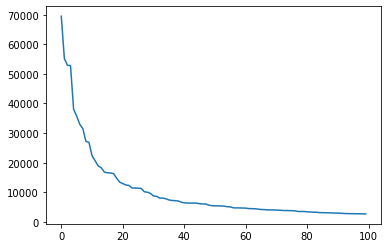

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

#### Решение:

Разобьем наши данные на 3 равные части с высокой частотой встречания, со средней частотой встречания и с нижней частотой встречания 

In [10]:
one_of_tree_part = round(len(corpus) / 3)
higth_freq = []
midle_freq = []
low_freq = []

current_sum_freq, i, all_lists = 0, 0, [higth_freq, midle_freq, low_freq]
current_list = 0
while True:
    all_lists[current_list].append(freq_dict_sorted[i])
    current_sum_freq += freq_dict_sorted[i][1]
    if current_sum_freq >= one_of_tree_part:
        current_list += 1
        current_sum_freq = 0
        if current_list == len(all_lists)-1:
            all_lists[-1].extend(freq_dict_sorted[i:])
            break
    i += 1

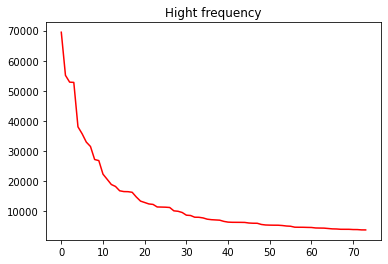

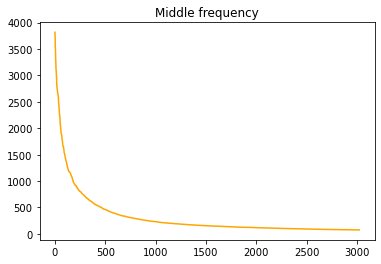

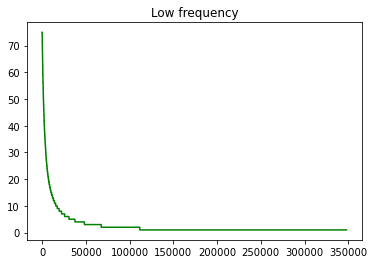

In [11]:
colors = ['red', 'orange', 'green']
titles = ['Hight frequency', 'Middle frequency', 'Low frequency']
for i, current_freq_list in enumerate(all_lists):
    plt.plot(sorted(dict(current_freq_list).values(), reverse=True), c=colors[i])
    plt.title(titles[i])
    plt.show()

В качестве классификатора выберем линейный классификатор:

In [60]:
for i, current_freq_list in enumerate(all_lists):
    vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize, 
                          max_df=max((dict(current_freq_list).values())), 
                          min_df=min(dict(current_freq_list).values()))

    bow = vec.fit_transform(x_train)
    clf = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
    clf.fit(bow, y_train)
    pred = clf.predict(vec.transform(x_test))
    print(titles[i] + ':')
    print(classification_report(pred, y_test))

Hight frequency:
              precision    recall  f1-score   support

    negative       0.73      0.63      0.68     32649
    positive       0.58      0.69      0.63     24060

    accuracy                           0.65     56709
   macro avg       0.65      0.66      0.65     56709
weighted avg       0.67      0.65      0.66     56709

Middle frequency:
              precision    recall  f1-score   support

    negative       0.65      0.72      0.68     25008
    positive       0.76      0.69      0.72     31701

    accuracy                           0.70     56709
   macro avg       0.70      0.70      0.70     56709
weighted avg       0.71      0.70      0.70     56709

Low frequency:
              precision    recall  f1-score   support

    negative       0.74      0.66      0.69     31250
    positive       0.63      0.71      0.67     25459

    accuracy                           0.68     56709
   macro avg       0.68      0.68      0.68     56709
weighted avg       0.69 

In [59]:
higth_freq

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860),
 ('...', 22363),
 ('меня', 20656),
 ('у', 18928),
 ('как', 18279),
 ('так', 16839),
 ('D', 16575),
 ('это', 16542),
 ('мне', 16337),
 ('все', 14763),
 ('ты', 13412),
 ('но', 12949),
 ("''", 12471),
 ('Я', 12315),
 ('``', 11467),
 ('то', 11432),
 ('..', 11392),
 ('по', 11294),
 ('уже', 10180),
 ('за', 10038),
 ('же', 9628),
 ('ну', 8742),
 ('А', 8635),
 ('только', 8065),
 ('бы', 8041),
 ('еще', 7829),
 ('да', 7413),
 ('вот', 7244),
 ('тебя', 7161),
 ('нет', 7078),
 ('когда', 6676),
 ('очень', 6436),
 ('сегодня', 6377),
 ('будет', 6368),
 ('к', 6357),
 ('день', 6332),
 ('хочу', 6137),
 ('он', 6064),
 ('просто', 6052),
 ('от', 5654),
 ('было', 5484),
 ('тебе', 5436),
 ('мы', 5414),
 ('из', 5406),
 ('И', 5308),
 ('тоже', 5142),
 ('—', 5063),
 ('до', 4749),
 ('надо', 4731),
 ('там', 4723),
 ('даже', 4683),
 ('его', 4655),
 ('теперь', 4

**ВЫВОДЫ**: 

Наиболее выжными словами для определения семантки твита, являются слова со средней и низкой частотой употреблия. И действительно, в часто всречаемые слова входят таким слова, такие части речи, как союзы, предлоги, слова связки и т.д., которые по сути не несут никакого смысла для задачи определения тональности.

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [2]:
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [3]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     28091
    positive       1.00      1.00      1.00     28618

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [17]:
sorted_vocabulary = sorted(vec.vocabulary_.items(), key=lambda x: x[1])
word_weight_vocabulary = {word: clf.coef_[0][i] for i, (word, embd) in enumerate(sorted_vocabulary)}
sorted(word_weight_vocabulary.items(), key=lambda x: abs(x[1]), reverse=True)

[('(', -59.72519944921544),
 (')', 58.38688263739335),
 ('d', 26.841652456772724),
 ('|', -11.125803279765476),
 ('о_о', -10.95150965397659),
 ('dd', 10.462663238568366),
 ('^_^', 9.094123136354247),
 ('-/', -8.677209434119987),
 ('o_o', -8.599522609906066),
 ('ddd', 7.956102525075986),
 ('-d', 7.665356668712802),
 ('*', 7.247944057108238),
 (':', 5.799590933103087),
 ('cio_optimal', -5.3994318643258765),
 ('to_over_kill', -5.377539297889741),
 ('dddd', 4.685972435246835),
 ('do_or_die_xxx', -4.494404190557016),
 ('prisonero_o', -4.249806530170253),
 ('rt', -4.017994178794804),
 ('reno_oppa', -3.849864241626324),
 ('horanso_on', -3.3684981156493143),
 ('ddddd', 3.144783918330946),
 ('kota_oo_oo', -3.010869920876786),
 ('boo_ohoo', -2.93525287258348),
 ('_do_or_die__', -2.839593802440927),
 ('снаступающимтвиттерский', -2.6973943243244034),
 ('o_obnulyay', -2.5309949399077145),
 ('radio_of_moon', -2.472756411517806),
 ('lponomarenko_o', -2.244175243937088),
 ('mo_onmery', -2.235447344214

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [19]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     33089
    positive       0.83      1.00      0.91     23620

    accuracy                           0.91     56709
   macro avg       0.91      0.93      0.91     56709
weighted avg       0.93      0.91      0.92     56709



**ВЫВОДЫ**: 

Как и ожидалось, смайлики (скобки, двоеточие и т.д.) лучше всего описывают эмоциональный окрас твита

## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, max_iter=300)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/Users/janeyaromich/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.99      1.00      0.99     28119
    positive       1.00      0.99      0.99     28590

    accuracy                           0.99     56709
   macro avg       0.99      0.99      0.99     56709
weighted avg       0.99      0.99      0.99     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или инчае, на символах классифицировать тоже можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

In [1]:
import nltk
from string import punctuation
from stop_words import get_stop_words

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Для сравнения именно токенизаторов, уберем всю пунктуацию. Для уменьшения признакового пространства будем использовать библиотеку stop_words

In [55]:
vectorizers = [CountVectorizer, TfidfVectorizer, HashingVectorizer]

for vectorizer in vectorizers:
    vector = vectorizer(analyzer='word',
                        ngram_range=(1,1),
                        tokenizer=nltk.word_tokenize, 
                        stop_words=get_stop_words('russian') + list(punctuation))

    bow = vector.fit_transform(x_train)
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(bow, y_train)
    y_pred = model.predict(vector.transform(x_test))
    print('-' * 100)
    print(vectorizer.__name__, 'classification reports:')
    print('-' * 100)
    print(classification_report(y_test, y_pred))


----------------------------------------------------------------------------------------------------
CountVectorizer classification reports:
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.77      0.79      0.78     28242
    positive       0.79      0.76      0.77     28467

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709

----------------------------------------------------------------------------------------------------
TfidfVectorizer classification reports:
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.78      0.76      0.77     28242
    positive       0.77      0.78      0.77     28467

    accuracy             

In [2]:
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = [1] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = [0] * len(negative)
df = positive.append(negative)

x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

2) подобрать оптимальный размер для hashing векторайзера 



Поиск оптимальной размерности вектора будем проводить по набору параметров с контролем метрики accuracy

In [19]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

accuracies = []
n_features_values = [20, 2 ** 5, 2 ** 8, 2 ** 10, 2 ** 12, 2 ** 15, 2 ** 18, 2 ** 20]
needed_times = []
for n_features in tqdm(n_features_values):
    start_time = time.time()
    vector = HashingVectorizer(analyzer='word',
                            ngram_range=(1,1),
                            tokenizer=nltk.word_tokenize, 
                            stop_words=get_stop_words('russian') + list(punctuation),
                            n_features=n_features
                        )

    bow = vector.fit_transform(x_train)
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(bow, y_train)
    y_pred = model.predict(vector.transform(x_test))
    accuracies.append(accuracy_score(y_true=y_test, y_pred=y_pred))
    needed_times.append(time.time() - start_time)


100%|██████████| 8/8 [07:14<00:00, 54.29s/it]


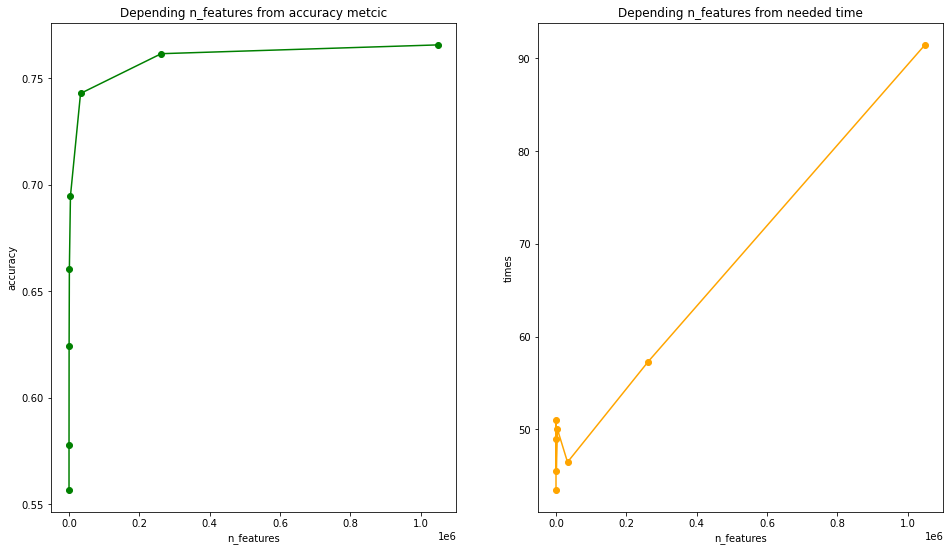

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
ax1 = plt.subplot(1, 2, 1)
plt.plot(n_features_values, accuracies, '-o', c='green')
plt.xlabel('n_features')
plt.ylabel('accuracy')
plt.title('Depending n_features from accuracy metcic')

ax2 = plt.subplot(1, 2, 2)
plt.plot(n_features_values, needed_times, '-o', c='orange')
plt.xlabel('n_features')
plt.ylabel('times')
plt.title('Depending n_features from needed time')

plt.show()

Конечно выбор размера embeding зависит от ресурсов, которые нам доступны. Но также можно использовать принцип локтя и выбрать оптимальный n_features из графика выше. В нашем случае - это 2 ** 15. Увеличивая значение n_features выше мы незначительно увеличиваем accuracy, но значительно увеличиваем время работы 

3) убедиться что для сетки нет переобучения

При обучении нейронной сети, контроль за переобучением происходит, путем наблюдения за метриками на отложеной выборке. Из приложено ноутбука виднл, что переобучение нет.